In [1]:
import os
import re
import glob
import pandas as pd
import csv
from sklearn.cross_decomposition import CCA
from sklearn.utils import resample
from sklearn.utils import shuffle
import load_approved_data
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import matplotlib.ticker as ticker

c:\users\grace\appdata\local\programs\python\python36\lib\importlib\_bootstrap_external.py:426: ImportWarning: Not importing directory c:\users\grace\appdata\local\programs\python\python36\lib\site-packages\google: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
c:\users\grace\appdata\local\programs\python\python36\lib\importlib\_bootstrap_external.py:426: ImportWarning: Not importing directory c:\users\grace\appdata\local\programs\python\python36\lib\site-packages\mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
bootstrap_iters = 5
n_cca_components = 52

In [4]:
#read in behavioural/demogrpahic data to pandas dataframe
demographics_data_filename = r'Project\data\original\ukb46307_with_civet_reduced.tab'
demographics_data = pd.read_csv(demographics_data_filename, header=0,  index_col='f.eid', sep='\t')

In [5]:
#ensure number of participants is as expected
all_ids = demographics_data.index.tolist()
print("Participants: " + str(len(all_ids)))

Participants: 26508


In [6]:
#drop the count of null columns (used in shrink_ukbb script)
demographics_data = demographics_data.drop(columns=['countnull'])

In [ ]:
#next four steps ensures columns are zscored, nulls are filled in, and categorical columns are marked as such

In [9]:
demo_cols = demographics_data.columns

In [11]:
col_name_dict_file = r'Project/data/supplemental/ColumnHeaders-WrittenNames-Shortform.csv'
col_readable_name_dict = pd.read_csv(col_name_dict_file, header=None, index_col=0, squeeze=True).to_dict()

In [12]:
demo_cols_categorical = ['f.31.0.0','f.971.2.0', 'f.981.2.0', 'f.991.2.0', 'f.1001.2.0', 'f.1011.2.0', 'f.1021.2.0', 'f.1031.2.0', 'f.1249.2.0', 'f.1259.2.0', 'f.2634.2.0', 'f.3393.2.0', 'f.3637.2.0', 'f.3647.2.0', 'f.4792.2.0', 'f.4803.2.0', 'f.6160.2.1', 'f.6160.2.2', 'f.6160.2.3', 'f.6160.2.4', 'f.20160.2.0']
for col_name in  demo_cols:
    if col_name in demo_cols_categorical:
        #change column type to category
        demographics_data[col_name] = demographics_data[col_name].astype('category')
        if 0 in demographics_data[col_name].cat.categories:
            if -1 in demographics_data[col_name].cat.categories:
                demographics_data[col_name] = demographics_data[col_name].cat.add_categories('-1.0').fillna('-1.0')
            else:
                demographics_data[col_name] = demographics_data[col_name].cat.add_categories('-4.0').fillna('-4.0')
        else:
            demographics_data[col_name] = demographics_data[col_name].cat.add_categories('0').fillna('0')
        #add category to encompass nulls
        #demographics_data[col_name] = demographics_data[col_name].cat.add_categories('-1.0').fillna('-1.0')
    else:
        demographics_data[col_name] = demographics_data[col_name].fillna(demographics_data[col_name].mean())
        demographics_data[col_name] = zscore(demographics_data[col_name])

In [13]:
demographics_data = demographics_data.fillna(demographics_data.mean())

In [14]:
#read in vertex data (reduced)
component_file_location = r'F:valid//all_600_pcas_vertex.csv' #could be pca, ica, spectral, or aal
vertexes_data = pd.read_csv(component_file_location, header=None, index_col=0)

In [15]:
vert_cols = vertexes_data.columns

In [16]:
print(vertexes_data.shape)
print(demographics_data.shape)

(25043, 600)
(26508, 52)


In [17]:
#exclude participants who don't have either demographic or vertex data
demographics_data = pd.merge(vertexes_data,demographics_data,how="inner",left_index=True,right_index=True)[demo_cols]

In [18]:
#make sure all participants are in same order across data sets
vertexes_data.sort_index(inplace=True, ascending=True)
demographics_data.sort_index(inplace=True, ascending=True)

In [19]:
print(vertexes_data.shape)
print(demographics_data.shape)

(25043, 600)
(25043, 52)


In [20]:
#create and run CCA model
cca_model = CCA(n_components=52)
cca_model.fit(demographics_data,vertexes_data)

#calculate the canonical correlation coefficients for each mode
demographics_data_T, vertexes_data_T = cca_model.transform(demographics_data,vertexes_data)
#print(demographics_data_T.shape)
#print(vertexes_data_T.shape)
result = np.corrcoef(demographics_data_T.T, vertexes_data_T.T).diagonal(offset=cca_model.n_components) 

(25043, 52)
(25043, 52)


Text(0.5, 1.0, 'Canonical correlations')

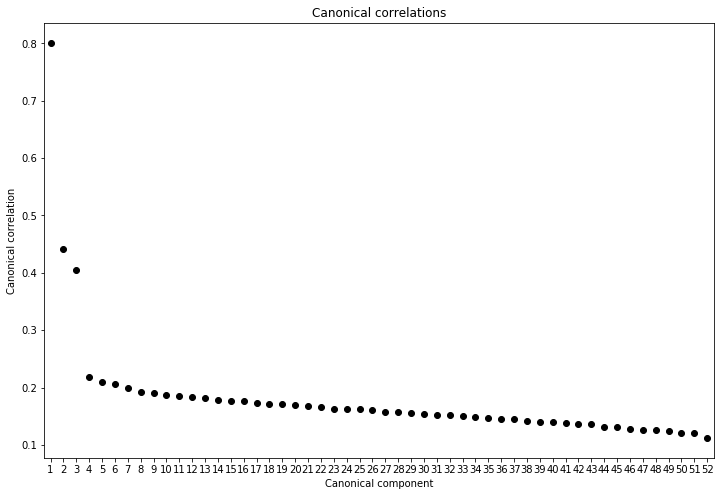

In [21]:
#plot the canonical correlations for each mode
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(np.arange(cca_model.n_components)+1, result, 'ko')
plt.xlim(.5, .5+cca_model.n_components)
plt.xticks(np.arange(cca_model.n_components)+1)
plt.xlabel('Canonical component')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlations')

In [23]:
X_weights = cca_model.x_weights_
X_loadings = cca_model.x_loadings_
Y_weights = cca_model.y_weights_
Y_loadings = cca_model.y_loadings_
coefficients = cca_model.coef_

In [ ]:
my_coef_counts = dict()
my_x_loadings = dict()
for x_load in X_loadings.transpose():
    #print(x_load)
    my_x_loadings[repr(x_load)] = 1
for coef in coefficients:
    #print(coef.shape)
    #Note: use repr to convert coef to string since can't hash numpy array
    my_coef_counts[repr(coef)] = 1 

In [24]:
x_loading_fileout = r'Project\data\cca_model_demographic_loadings.csv'
with open(x_loading_fileout, 'w') as f:
    cwriter = csv.writer(f, delimiter=',', lineterminator='\n')
    cwriter.writerows(X_loadings)

In [25]:
y_loading_fileout = r'Project\data\cca_model_vertex_loadings.csv'
with open(y_loading_fileout, 'w') as f:
    cwriter = csv.writer(f, delimiter=',', lineterminator='\n')
    cwriter.writerows(Y_loadings)

In [22]:
#initialize an array to hold the correlation coefficients from the permutations
corrcoefs_bstrap = np.zeros((n_cca_components, bootstrap_iters))
print(corrcoefs_bstrap.shape)
fwe_vals = np.zeros((n_cca_components,1))
count_bins=np.zeros(10)

(52, 5)


In [25]:
corrcoefs_bstrap_ls = []

In [26]:
#function to fun cca permutations with broken linkages between the demographics and vertexes
def run_shuffled_cca(ddata,vdata, ix):
    demographics_shuffled, vertexes_shuffled = shuffle(ddata, vdata, random_state=ix)
    #vertexes_shuffled = shuffle(vertexes)
    cca_model_shuffled = CCA(n_components=n_cca_components)
    cca_model_shuffled.fit(ddata,vertexes_shuffled)
    #coefficients_temp = cca_model_shuffled.coef_
    #X_loadings_temp = cca_model_shuffled.x_loadings_
    #Y_loadings_temp = cca_model_shuffled.y_loadings_
    test1_c, test2_c = cca_model_shuffled.transform(ddata, vertexes_shuffled)
    testcorrs = np.corrcoef(test1_c.T, test2_c.T).diagonal(offset=cca_model_shuffled.n_components)
    return testcorrs

In [27]:
print(time.ctime(time.time()))

#run permutations of CCA
for b_iter in range(0,bootstrap_iters):
    #corrcoefs_bstrap[:,b_iter] = run_shuffled_cca(demographics_data,vertexes_data)
    corrcoefs_bstrap_ls.append(run_shuffled_cca(demographics_data,vertexes_data,b_iter))
    if b_iter % 10 == 0:
        print(str(b_iter) + " at " + time.ctime(time.time()))

Fri Apr  8 11:26:11 2022
0 at Fri Apr  8 11:36:05 2022
1649432165.0888963


In [35]:
#save the mean and percentile info from the permutations for plotting
corrcoefs_bstrap = np.array(corrcoefs_bstrap_ls)
corrcoefs_bstrap_means = corrcoefs_bstrap.mean(axis=0)
corrcoefs_bstrap_5p = np.percentile(corrcoefs_bstrap, 5, axis=0)
corrcoefs_bstrap_95p = np.percentile(corrcoefs_bstrap, 95, axis=0)

In [38]:
corrcoefs_bstrap_fileout = r'Project\data\corrcoefs_bstrap.csv'
with open(corrcoefs_bstrap_fileout, 'w') as f:
    cwriter = csv.writer(f, delimiter=',', lineterminator='\n')
    cwriter.writerows(corrcoefs_bstrap)

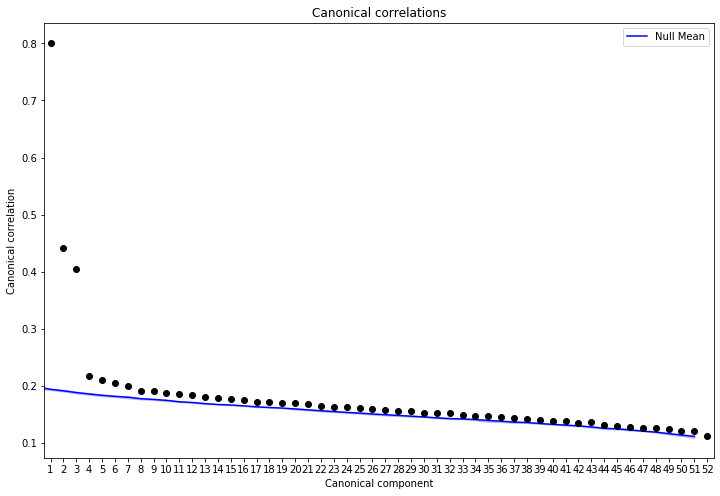

In [36]:
#plot the original canoncial correlations as well as the permutation ones
x = np.arange(len(corrcoefs_bstrap_means))
plt.plot(x, corrcoefs_bstrap_means, 'b-', label='Null Mean')
plt.fill_between(x, corrcoefs_bstrap_5p, corrcoefs_bstrap_95p, color='b', alpha=0.2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(np.arange(cca_model.n_components)+1, result, 'ko')
plt.xlim(.5, .5+cca_model.n_components)
plt.xticks(np.arange(cca_model.n_components)+1)
plt.xlabel('Canonical component')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlations')
plt.legend()
plt.show()

In [ ]:
for comp_x in range(0,n_cca_components):
    corr_x = result[comp_x]
    temp_compare = np.zeros(bootstrap_iters)
    for b_iter in range(0,bootstrap_iters):
        if corr_x < corrcoefs_bstrap[0,b_iter]:
            temp_compare[b_iter] = 1
        else:
            temp_compare[b_iter] = 0
    fwe_vals[comp_x] = (1+sum(temp_compare))/bootstrap_iters
    #print(temp_compare)
    #print(corr_x, fwe_vals[comp_x])
#print(fwe_vals)